# data_treatment

## Notebook Criticals

In [10]:
# custom analysis tools
from analysis.scan import scan
from analysis.tools import extract_species
from analysis.tools import muon_filter
from analysis.tools import muon_filter_by_parts
from analysis.tools import norm_df
from analysis.tools import diff_df
from analysis.tools import ambience_250
from analysis.tools import ambience_320
from analysis.tools import ambience_435

# useful python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from prettytable import PrettyTable

plt.rcParams['figure.figsize'] = 26, 10
plt.style.use('ggplot')

ratio_250 = 12.185
ratio_260 = 12.743
ratio_320 = 13
ratio_435 = 11.703

In [11]:
STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

In [12]:
# Irradiation group
LiF_irrad                = extract_species(path, 'LiF', ext='irrad') 
LiF_irrad_samples = [ 'LiF_B2_145', 'LiF_B2_157', 'LiF_B2_158']

BaF_irrad                = extract_species(path, 'BaF', ext='irrad') 
BaF_irrad_samples = ['BaF_B2_181','BaF_B2_183', 'BaF_B2_185', 'BaF_B2_192']

Qz_irrad                   = extract_species(path, 'Qz', ext='irrad') 
Qz_irrad_samples    = ['Qz_B2_063', 'Qz_B2_069', 'Qz_B2_072']

SP_irrad                   = extract_species(path, 'SP', ext='irrad') 
SP_irrad_samples     = ['SP4500', 'SP4501', 'SP4502', 'SP4503']

# Control group
LiF_ctrl                     = extract_species(path, 'LiF', ext='ctrl') 
LiF_ctrl_samples      = ['LiF_B2_143', 'LiF_B2_155']

BaF_ctrl                     = extract_species(path, 'BaF', ext='ctrl') 
BaF_ctrl_samples     = ['BaF_B2_182','BaF_B2_188', 'BaF_B2_193']

Qz_ctrl                        = extract_species(path, 'Qz', ext='ctrl') 
Qz_ctrl_samples         = ['Qz_B2_064',  'Qz_B2_071']

SP_ctrl                        = extract_species(path, 'SP', ext='ctrl') 
SP_ctrl_samples         = ['SP4504']

## Ambience Models

In [13]:
# Gaussian base functions

def Gaussian(x, A, m, s, offset = 0):
    return A * np.exp( -0.5 * ((x - m)**2) / (s**2) ) + offset

def Gaussian2(x, A1, m1, s1, A2, m2, s2):
    return Gaussian(x,A1,m1,s1) + Gaussian(x,A2,m2,s2)

def Gaussian3(x,A1, m1, s1, A2, m2, s2, A3, m3, s3):
    return Gaussian(x,A1,m1,s1) + Gaussian(x,A2,m2,s2) + Gaussian(x,A3,m3,s3)

def Gaussian4(x,A1, m1, s1, A2, m2, s2, A3, m3, s3, A4, m4, s4):
    return Gaussian(x,A1,m1,s1) + Gaussian(x,A2,m2,s2) + Gaussian(x,A3,m3,s3) + Gaussian(x,A4,m4,s4)

def offset_5Gaussians(x, A1, A2, A3, A4, A5, m1, m2, m3, m4, m5, s1, s2, s3, s4, s5, offset):
    a = Gaussian(x, A1, m1, s1)
    b = Gaussian(x, A2, m2, s2)
    c = Gaussian(x, A3, m3, s3)
    d = Gaussian(x, A4, m4, s4)
    e = Gaussian(x, A5, m5, s5)

    return a+b+c+d+e+offset

def lorentzian(x, A, m, g):
    """
    Lorentzian function.

    Parameters:
    - x: Input values (numpy array or scalar).
    - x0: Location parameter (peak position).
    - gamma: Scale parameter (half-width at half-maximum).
    - A: Amplitude parameter.

    Returns:
    - Array of function values at corresponding x.
    """
    return (A/np.pi) * (g / ((x - m)**2 + g**2))


def lorentzian2(x, A1, m1, g1, A2, m2, g2):
    return lorentzian(x, A1, m1, g1) + lorentzian(x, A2, m2, g2)

# Ambience functions ([A], [m], [s], offset)

model_params_250 = [  4.11988944 ,  5.757796 ,   19.6223119,   -9.69799666 , 10.5641773,
 439.936038 ,  495.69336435 ,546.57268588 ,601.7559566 , 605.42206786,
   5.89833756  , 7.48714367   ,5.44249217,  -5.82091785 , 12.98600865,
 315 ]

model_params_320 = [459.59349593, 967.84928263   ,4.98752523 ,315]

model_params_435 = [  8.76609133  ,10.46031313  ,50.51038021, -48.75345784 , 51.51011464,
 455.02892594, 491.74321717 ,546.72075592 ,601.35695421, 603.33838787,
   8.68728288 , 14.79082917  , 5.90917478  ,7.66695692 , 11.52427167,
 315]

def ambience_250(x):
    return offset_5Gaussians(x, *model_params_250)

def ambience_320(x):
    return Gaussian(x, *model_params_320)

def ambience_435(x):
    return offset_5Gaussians(x, *model_params_435)

def gen_ambience_df(func, x_vals):
    y_model  = np.array([func(x) for x in x_vals])
    data = {'em_wl' : x_vals, 'count' : y_model}
    df = pd.DataFrame(data)
    return df


def remove_nans(x,y, err):
    size = len(y)
    indexes = []
    for i in range(size):
        if np.isnan(y[i]):
            indexes.append(i)

    x_clean = np.delete(x, indexes)
    y_clean = np.delete(y, indexes)
    err_clean = np.delete(err, indexes)
    
    return x_clean, y_clean ,err_clean

def rebin_data(x, y, bin_size):
    """
    Rebin data by grouping x and y values into larger bins and normalizing.

    Parameters:
    - x: 1D array of x values.
    - y: 1D array of y values.
    - bin_size: Size of the new bins.

    Returns:
    - rebinned_x: 1D array of rebinned x values.
    - rebinned_y: 1D array of rebinned y values (normalized).
    """
    # Calculate the number of bins
    num_bins = len(x) // bin_size

    # Trim x and y to ensure a whole number of bins
    trimmed_x = x[:num_bins * bin_size]
    trimmed_y = y[:num_bins * bin_size]

    # Reshape and sum values within each bin, handling NaN values
    rebinned_x = np.mean(trimmed_x.reshape((num_bins, bin_size)), axis=1)
    rebinned_y_sum = np.nansum(trimmed_y.reshape((num_bins, bin_size)), axis=1)

    # Normalize by dividing by bin size
    rebinned_y = rebinned_y_sum / bin_size

    return rebinned_x, rebinned_y

ratio_250 = 12.185
ratio_260 = 12.743
ratio_320 = 13
ratio_435 = 11.703

## DF Handling Functions

In [58]:
def norm_df(group, sample, coll, wl, ambience, pw_ratio, pw_error_coeff = 0.01, its = 4):

    # Ambience functions ([A], [m], [s], offset)

    model_params_250 = [  4.11988944 ,  5.757796 ,   19.6223119,   -9.69799666 , 10.5641773,
     439.936038 ,  495.69336435 ,546.57268588 ,601.7559566 , 605.42206786,
       5.89833756  , 7.48714367   ,5.44249217,  -5.82091785 , 12.98600865,
     315 ]
    
    model_params_320 = [459.59349593, 967.84928263   ,4.98752523 ,315]
    
    model_params_435 = [  8.76609133  ,10.46031313  ,50.51038021, -48.75345784 , 51.51011464,
     455.02892594, 491.74321717 ,546.72075592 ,601.35695421, 603.33838787,
       8.68728288 , 14.79082917  , 5.90917478  ,7.66695692 , 11.52427167,
     315]
    
    def ambience_250(x):
        return offset_5Gaussians(x, *model_params_250)
    
    def ambience_320(x):
        return Gaussian(x, *model_params_320)
    
    def ambience_435(x):
        return offset_5Gaussians(x, *model_params_435)
    
    def gen_ambience_df(func, x_vals):
        y_model  = np.array([func(x) for x in x_vals])
        data = {'em_wl' : x_vals, 'count' : y_model}
        df = pd.DataFrame(data)
        return df
    
    # the specific ambience model
    ambience_model = globals()[model]
    
    # extract df and meta_df from scan object
    df = group[f'coll{str(coll)}'][sample].df 
    meta = group[f'coll{str(coll)}'][sample].meta_df
    
    # get power sample arrays
    power_samples = meta.iloc[0]['pw'].astype(float)
    
    # get the exposure time
    t_exp = float(df.index[0][2].split('sec')[0])
    
    # filter df from background runs (its information has been used elsewhere to make the ambience templates)
    df = df.drop(index=(wl, '0', f'{t_exp}sec', 'bg_0'))
    
    # add poissonian error column
    df['shot_noise'] = np.sqrt(df['count'])
    
    # reduced df (only the 'kind' index remains)
    df = df.loc[(wl, '0', f'{t_exp}sec')]
    
    # gen ambience model df
    em_wl = np.array(df['em_wl'])
    amb_df = gen_ambience_df(ambience_model, em_wl)
    
    # subtract ambience from count column
    count_sub = np.array(df['count']) - np.array(amb_df['count'])
    df['count'] = count_sub
    
    # divde over by exposure time
    count_time_norm = count_sub / t_exp
    df['count'] = count_time_norm
    
    # create power df to divide over by
    size = int(len(em_wl) / its)
    pw_arr = np.array([])
    for i in range(its):
        pw  = np.full((size), power_samples[i])
        pw_arr = np.concatenate((pw_arr,pw))
    
    pw_arr = (pw_arr*pw_ratio / 1e-6)
    
    df['power'] = pw_arr.astype(float)
    count_norm = count_time_norm / pw_arr
    df['count'] = count_norm
    
    # calculate the combined error
    shot_noise_arr = np.array(df['shot_noise'])
    delta_power_arr = pw_arr * pw_error_coeff
    dpdx = (1/t_exp) * (1/pw_arr) 
    dpdpw = - (count_sub/t_exp ) * (1/(pw_arr**2))
    
    delta_p = np.sqrt( (dpdx**2)*shot_noise_arr + (dpdpw**2)*delta_power_arr )
    
    # df with errors
    df['error'] = delta_p
    
    
    # combine all iterations
    sp = np.zeros(size)
    err = np.zeros(size)
    for i in range(its):
        sp_i               = muon_filter_by_parts(np.array(df['count'][f'sp_{i}']))
        sp = np.add(sp, sp_i)
        
        err_i =  np.array(df['error'][f'sp_{i}'])
        err = np.add(err, err_i**2)
    
    sp = sp / its
    err = np.sqrt(err) / its
    
    # final df (while cutting out first and last bin)
    df = pd.DataFrame({'em_wl' : em_wl[1:(size-1)], 'count' : sp[1:(size-1)], 'error' : err[1:(size-1)]})
    
    return df

def diff_df(df2, df1):

    diff = df2.copy()
    
    diff['count'] = df2['count'] - df1['count']
    diff['error'] = np.sqrt( (df2['error']**2) + (df1['error']**2)  )
    
    return diff

def run_analysis(group, sample, wl, model, ratio, toplot = False, show_err = False, err_color = 'blue', bins = 20, add_label = None):
    
    # get all collections
    s1 = norm_df(group, sample, 1, wl, model, ratio)
    x = s1['em_wl']; y1 = s1['count']; err1 = s1['error']
    
    s2 = norm_df(group, sample, 2, wl, model, ratio)
    y2 = s2['count']; err2 = s2['error']
    
    s3 = norm_df(group, sample, 3, wl, model, ratio)
    y3 = s3['count']; err3 = s3['error']
    
    s4 = norm_df(group, sample, 4, wl, model, ratio)
    y4 = s4['count']; err4 = s4['error']
    
    s5 = norm_df(group, sample, 5, wl, model, ratio)
    y5 = s5['count']; err5 = s5['error']
    
    s6 = norm_df(group, sample, 6, wl, model, ratio)
    y6 = s6['count']; err6 = s6['error']
    
    Y0= ( y1 + y2 + y3 ) / 3
    ERR0 = np.sqrt((err1**2) + (err2**2) + (err3**2))
    df0 = pd.DataFrame({'em_wl' : x, 'count' : Y0, 'error' : ERR0})
    
    Y1 = ( y4 + y5 + y6 ) / 3
    ERR1 = np.sqrt((err4**2) + (err5**2) + (err6**2))
    df1 = pd.DataFrame({'em_wl' : x, 'count' : Y1, 'error' : ERR1})
    
    DIFF = diff_df(df1, df0)
    
    X = np.array(DIFF['em_wl']); Y = np.array(DIFF['count']); ERR = np.array(DIFF['error'])
    X_b, Y_b = rebin_data(X,Y, bin_size = bins)

    if toplot == True:
    
        plt.scatter(X,Y, alpha = 0.35)
        plt.plot(X_b,Y_b, label = f'{add_label} {sample}', linewidth = 3)
        
        # Create a shaded region for the errors
        if show_err == True:
            plt.fill_between(X, Y - ERR, Y + ERR, alpha=0.07, color = err_color)
        plt.xlabel('Emission Wavelength [nm]', fontsize = 17)
        plt.ylabel(r'PE sec$^{-1} \; \mu W^{-1}$', fontsize = 17)
        plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
        plt.minorticks_on()
        plt.legend(fontsize = 15)

    return DIFF

## Data Display (A-Centres)

### BaF

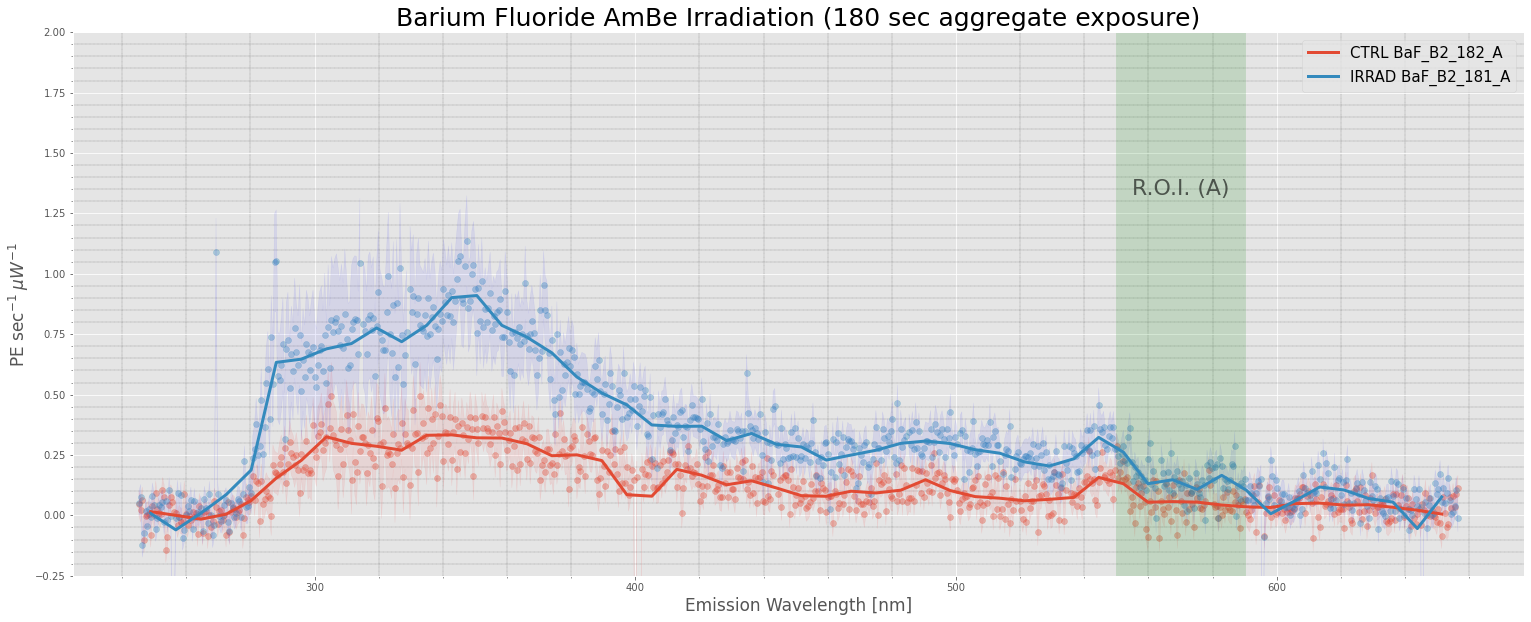

In [59]:
sample = 'BaF_B2_182_A'
wl           = '250'
group  = BaF_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)
plt.ylim(-0.25, 2)

sample = 'BaF_B2_181_A'
wl           = '250'
group  = BaF_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(550, 590, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(570, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

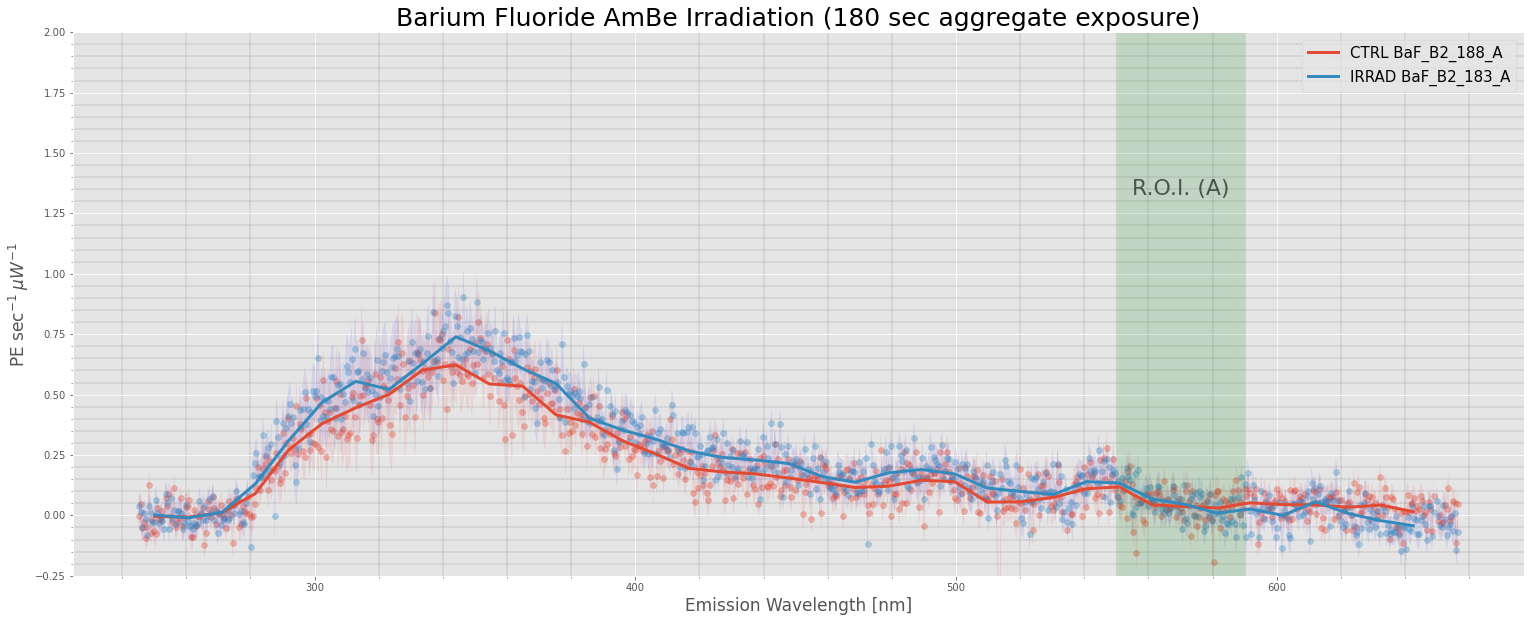

In [60]:
sample = 'BaF_B2_188_A'
wl           = '250'
group  = BaF_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL' ,err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'BaF_B2_183_A'
wl           = '250'
group  = BaF_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(550, 590, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(570, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

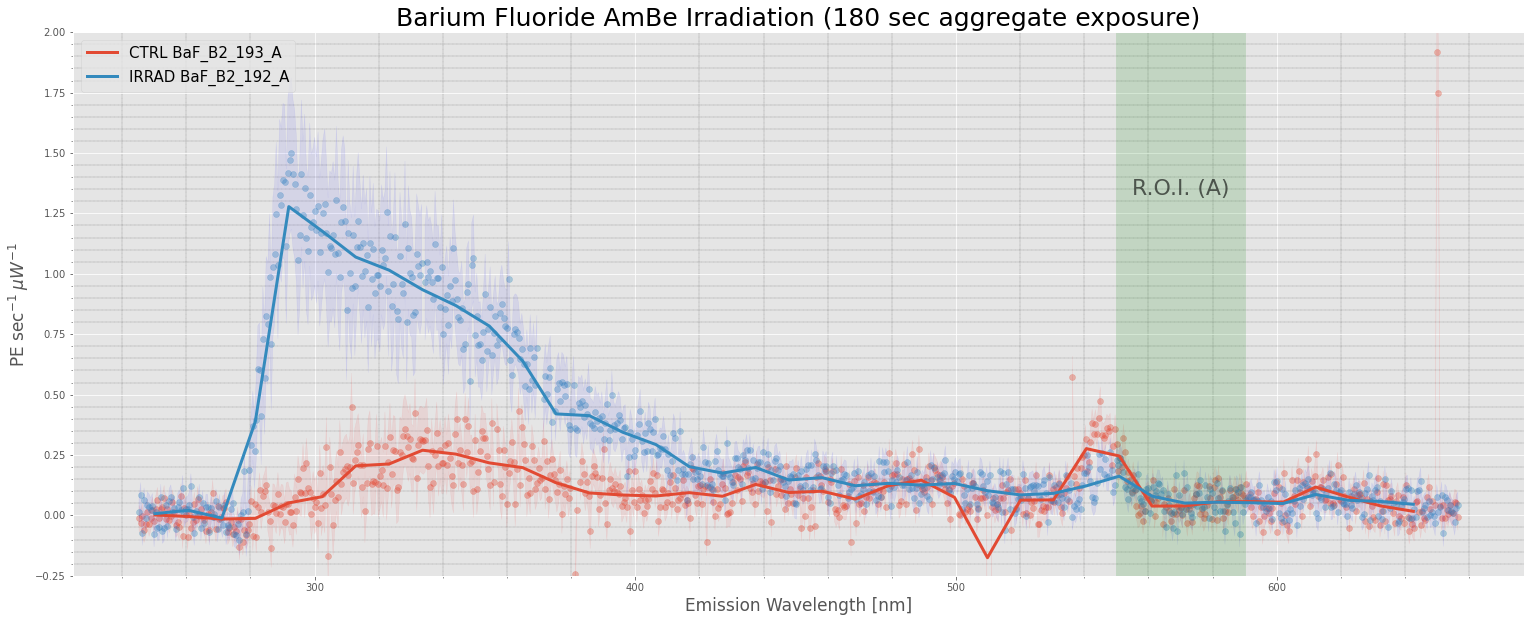

In [61]:
sample = 'BaF_B2_193_A'
wl           = '250'
group  = BaF_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL' ,err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'BaF_B2_192_A'
wl           = '250'
group  = BaF_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(550, 590, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(570, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

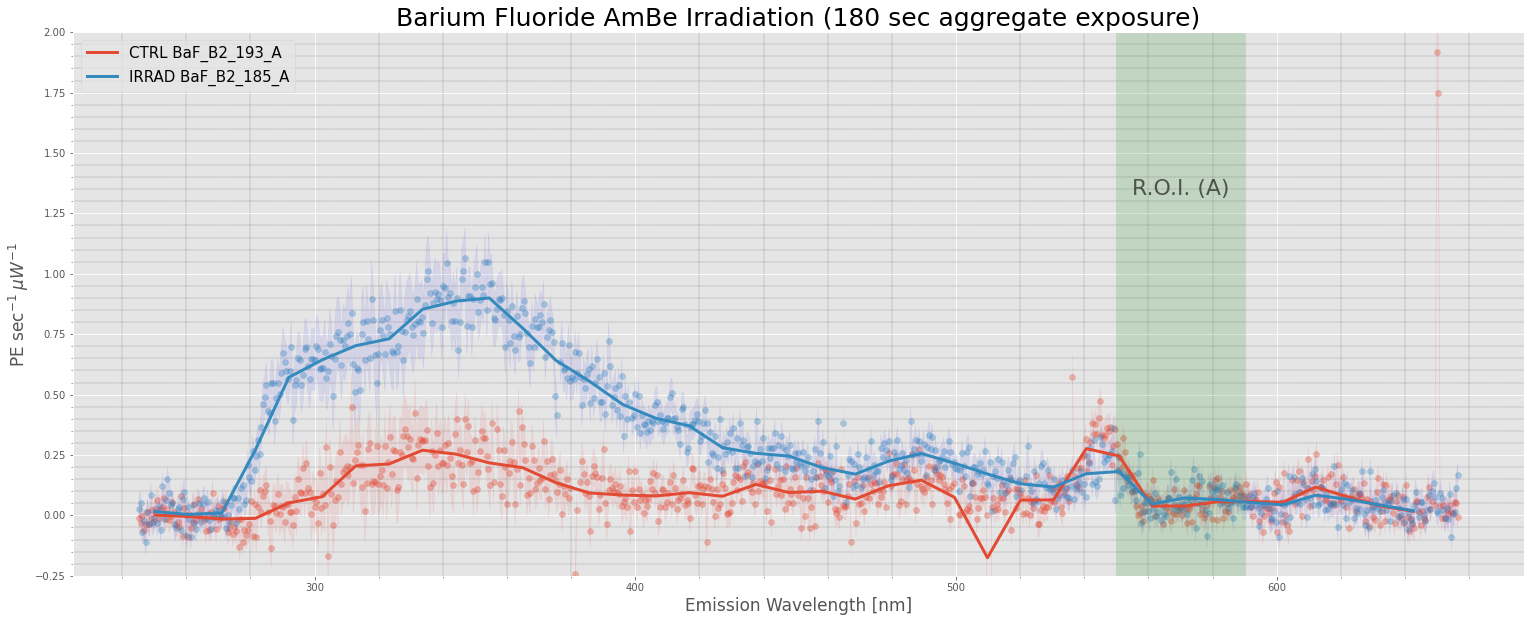

In [62]:
sample = 'BaF_B2_193_A'
wl           = '250'
group  = BaF_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL' ,err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'BaF_B2_185_A'
wl           = '250'
group  = BaF_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(550, 590, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(570, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

### LiF

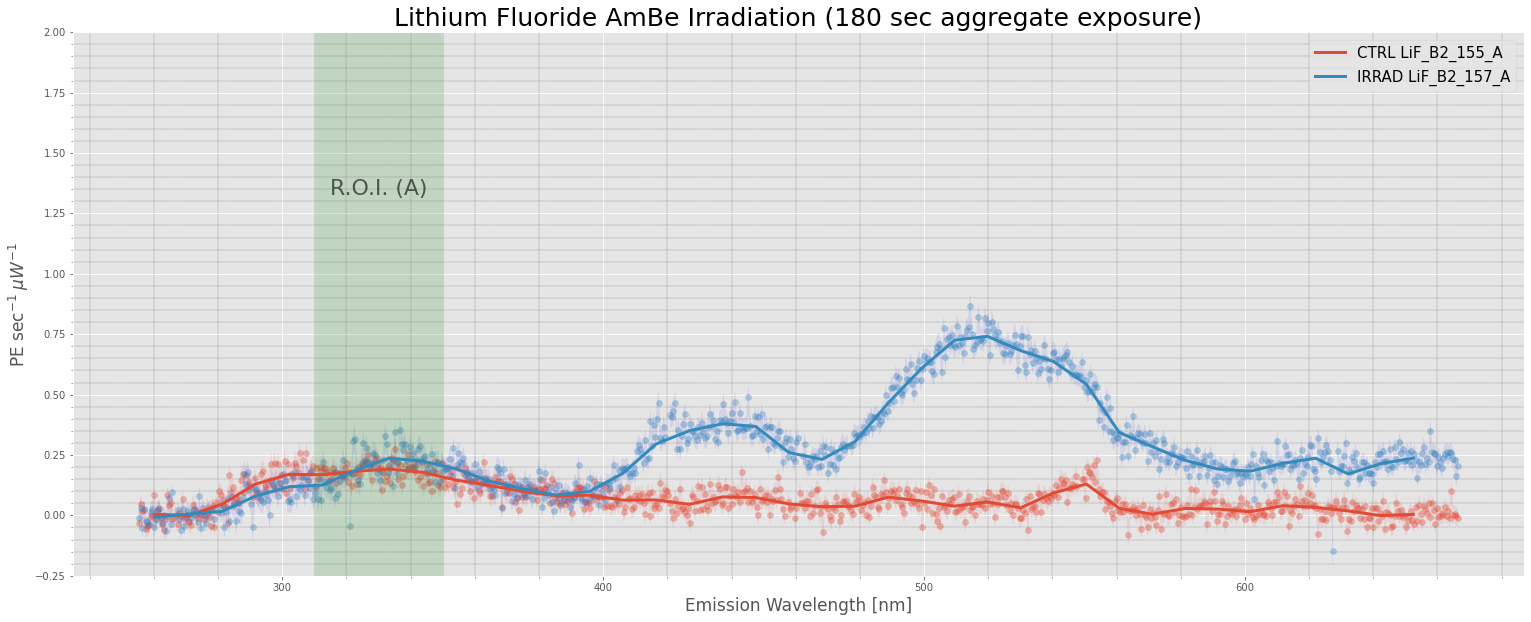

In [63]:
sample = 'LiF_B2_155_A'
wl           = '260'
group  = LiF_ctrl
model = 'ambience_250'
ratio = ratio_260

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL' ,err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'LiF_B2_157_A'
wl           = '260'
group  = LiF_irrad
model = 'ambience_250'
ratio = ratio_260

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(310, 350, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(330, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

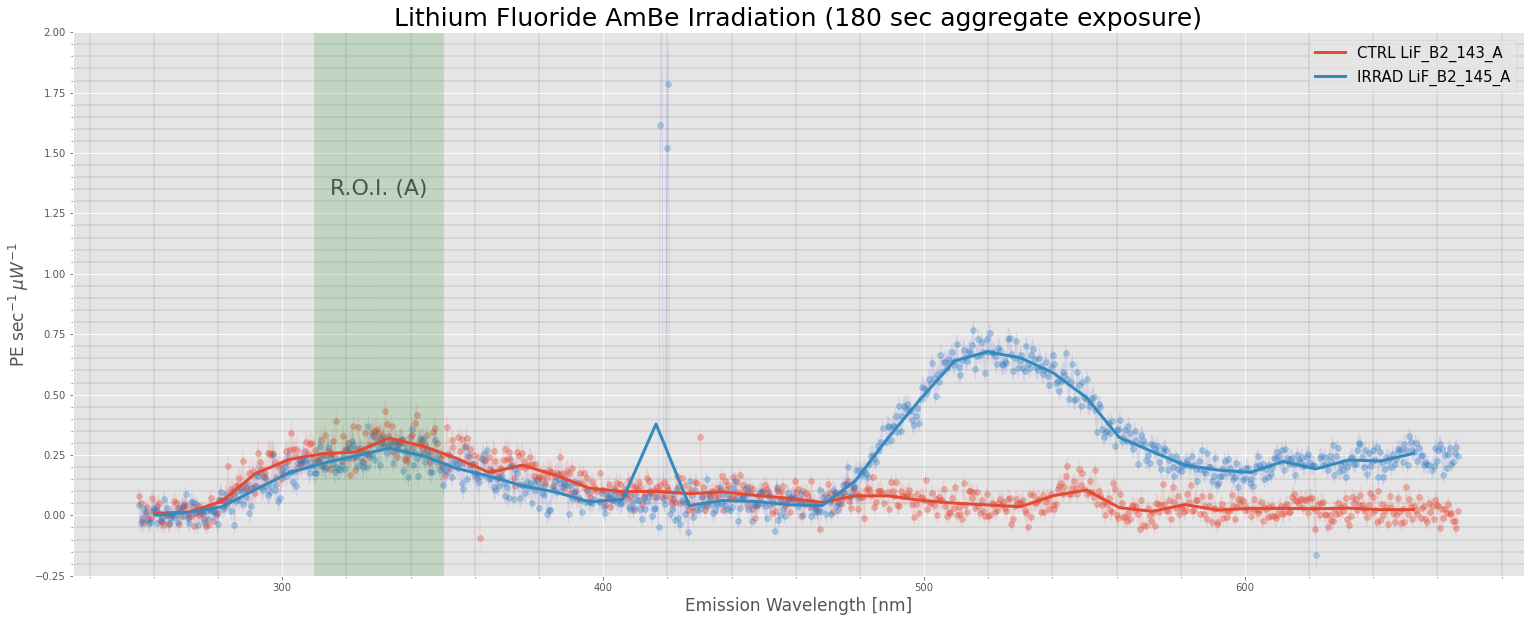

In [64]:
sample = 'LiF_B2_143_A'
wl           = '260'
group  = LiF_ctrl
model = 'ambience_250'
ratio = ratio_260

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True,  add_label = 'CTRL' ,err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'LiF_B2_145_A'
wl           = '260'
group  = LiF_irrad
model = 'ambience_250'
ratio = ratio_260

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(310, 350, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(330, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

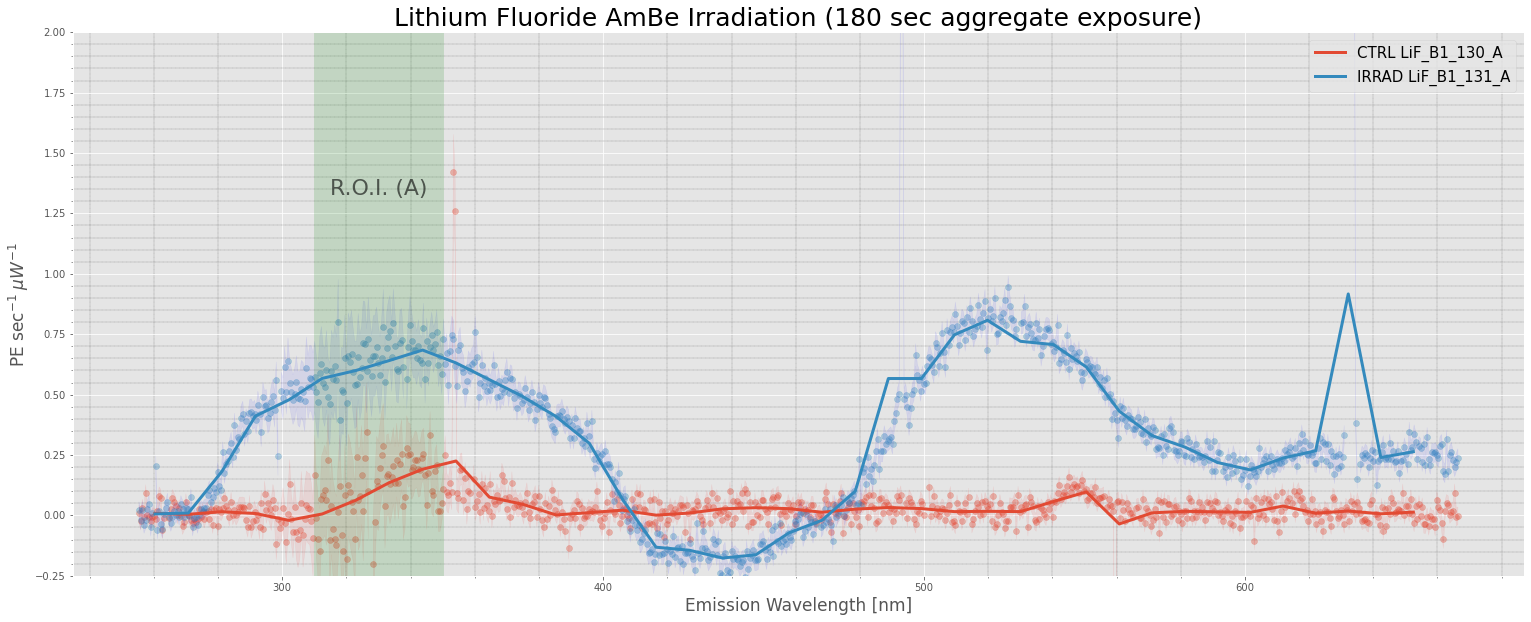

In [65]:
sample = 'LiF_B1_130_A'
wl           = '260'
group  = LiF_ctrl
model = 'ambience_250'
ratio = ratio_260

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL' ,err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'LiF_B1_131_A'
wl           = '260'
group  = LiF_irrad
model = 'ambience_250'
ratio = ratio_260

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(310, 350, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(330, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

### SP

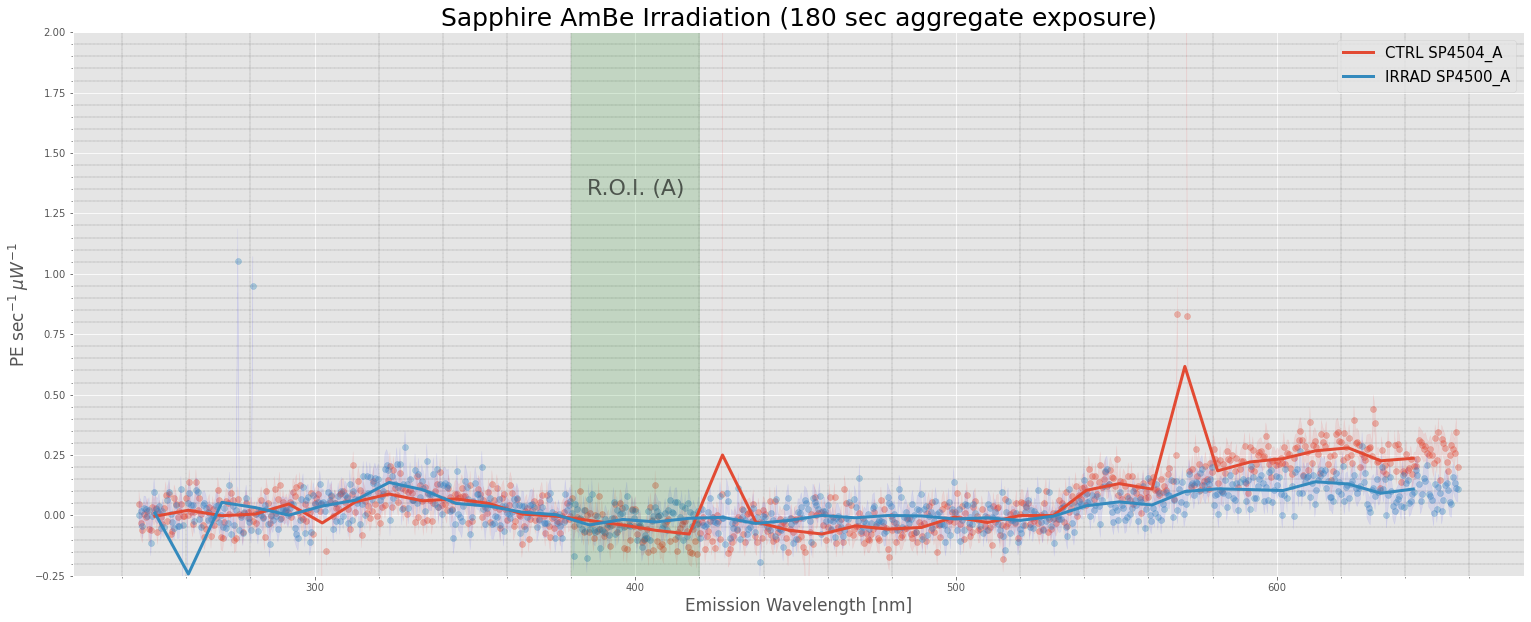

In [66]:
sample = 'SP4504_A'
wl           = '250'
group  = SP_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL',err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'SP4500_A'
wl           = '250'
group  = SP_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD',show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(380, 420, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(400, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Sapphire AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

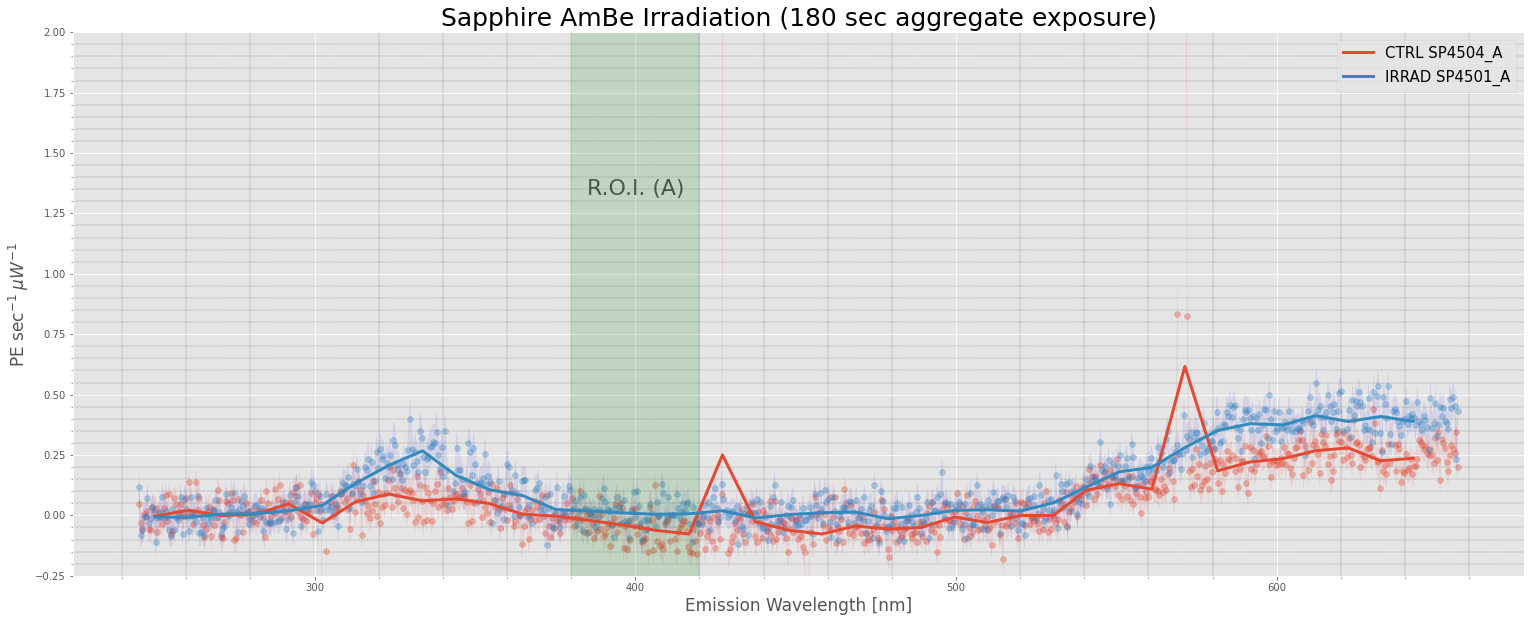

In [67]:
sample = 'SP4504_A'
wl           = '250'
group  = SP_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL',err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'SP4501_A'
wl           = '250'
group  = SP_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD' ,show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(380, 420, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(400, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Sapphire AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

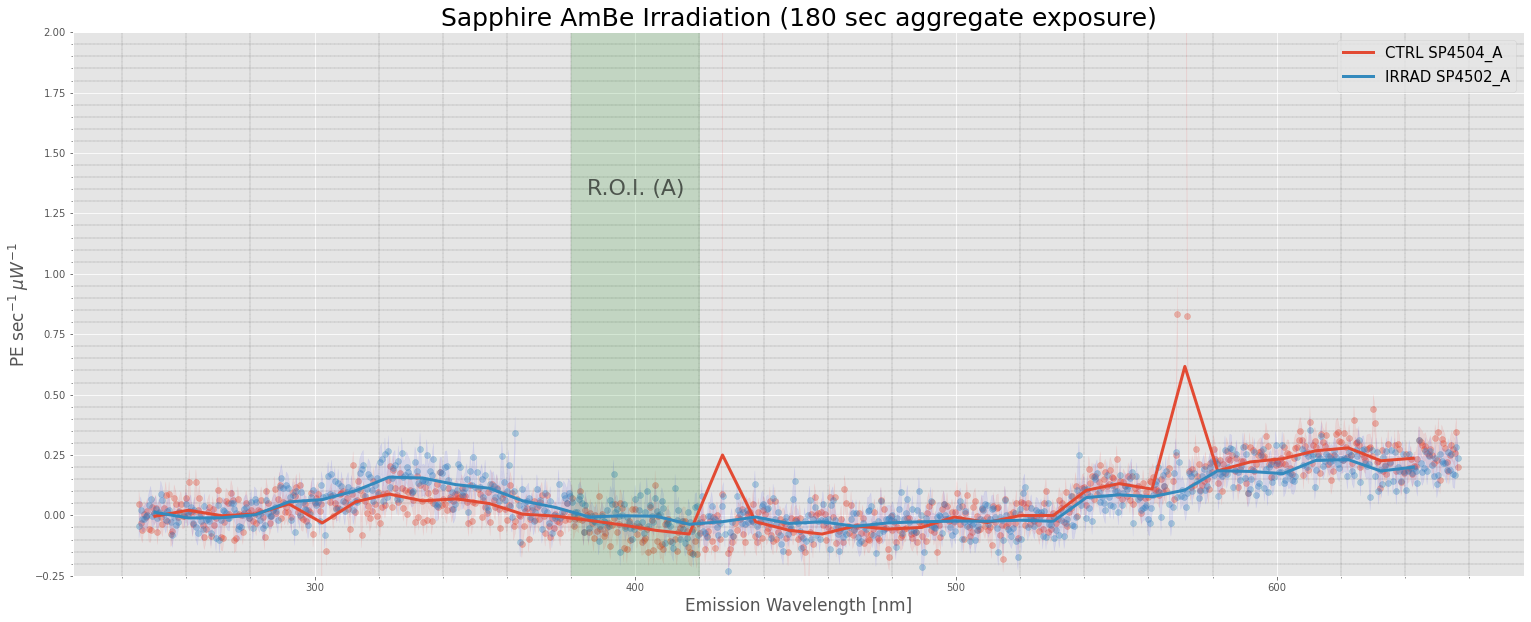

In [68]:
sample = 'SP4504_A'
wl           = '250'
group  = SP_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True,  add_label = 'CTRL',show_err=True, err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'SP4502_A'
wl           = '250'
group  = SP_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True,  add_label = 'IRRAD',show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(380, 420, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(400, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Sapphire AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

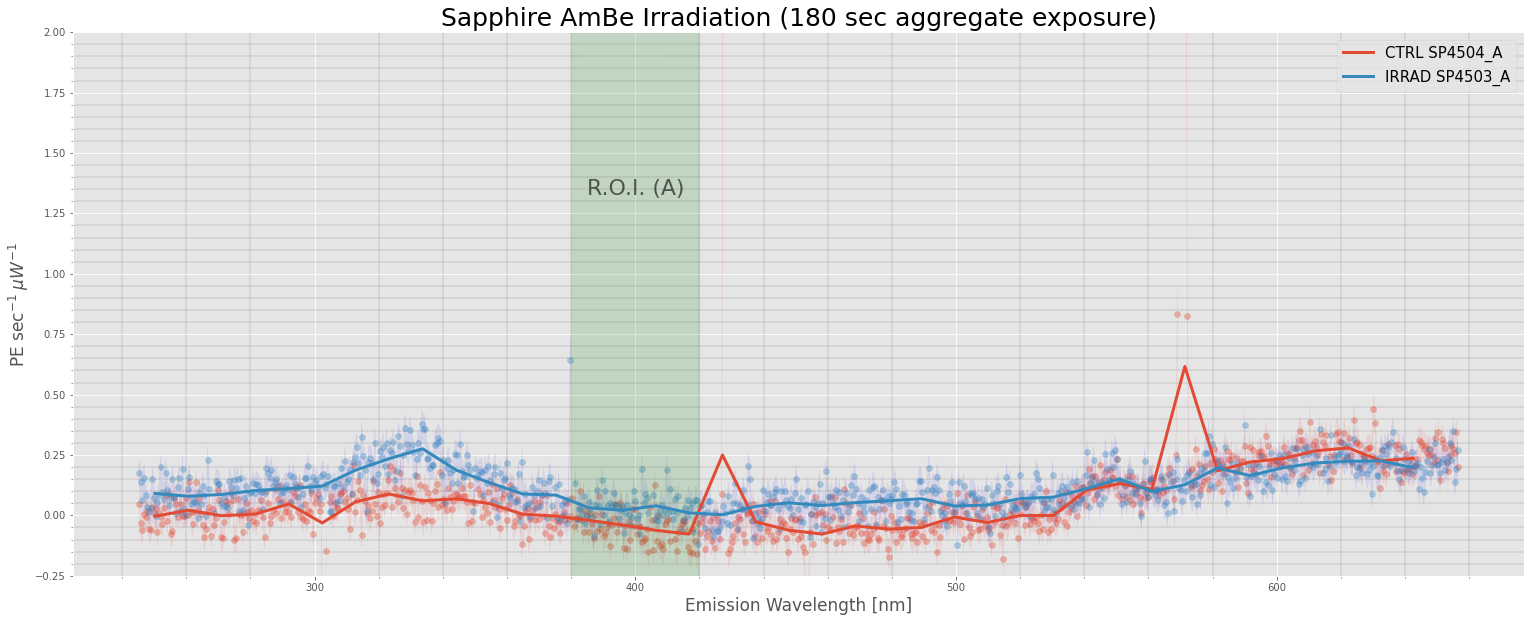

In [69]:
sample = 'SP4504_A'
wl           = '250'
group  = SP_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True,  add_label = 'CTRL',err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'SP4503_A'
wl           = '250'
group  = SP_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True,  add_label = 'IRRAD',show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(380, 420, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(400, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Sapphire AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

### Qz

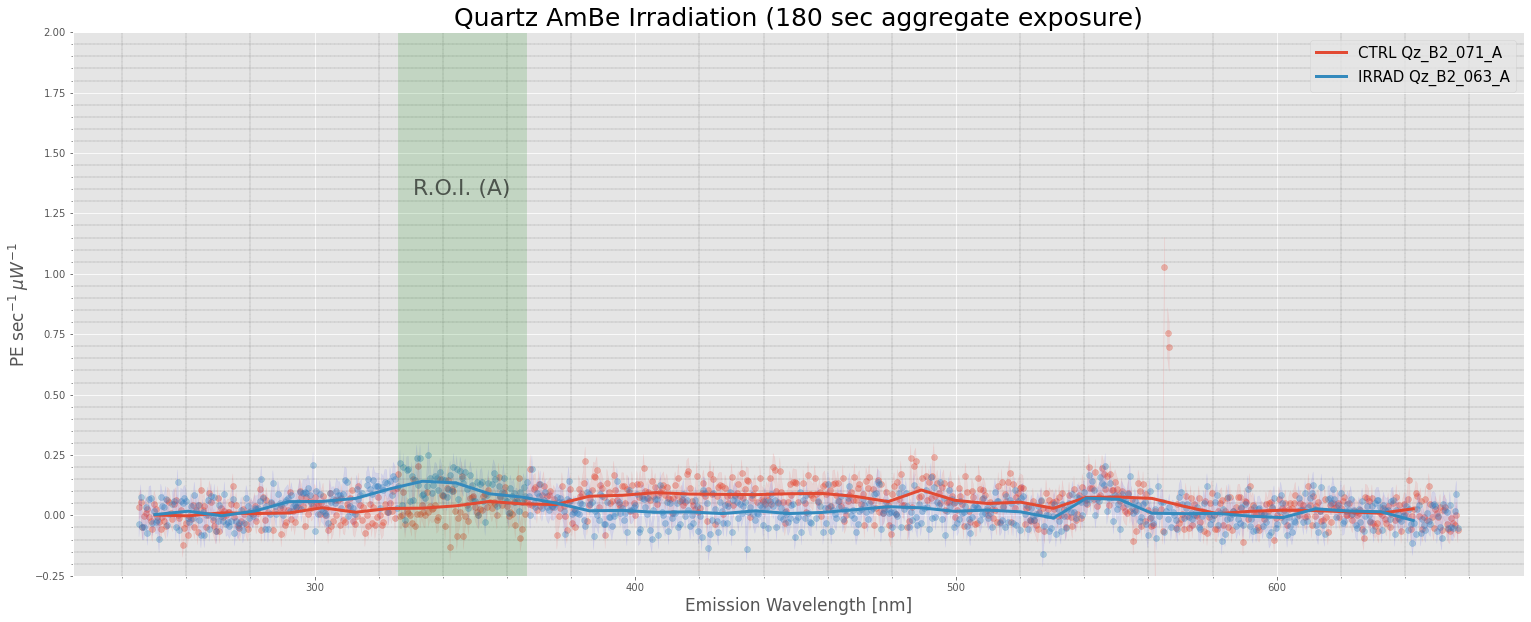

In [70]:
sample = 'Qz_B2_071_A'
wl           = '250'
group  = Qz_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True,add_label = 'CTRL', err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'Qz_B2_063_A'
wl           = '250'
group  = Qz_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD',show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(326, 366, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(346, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Quartz AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

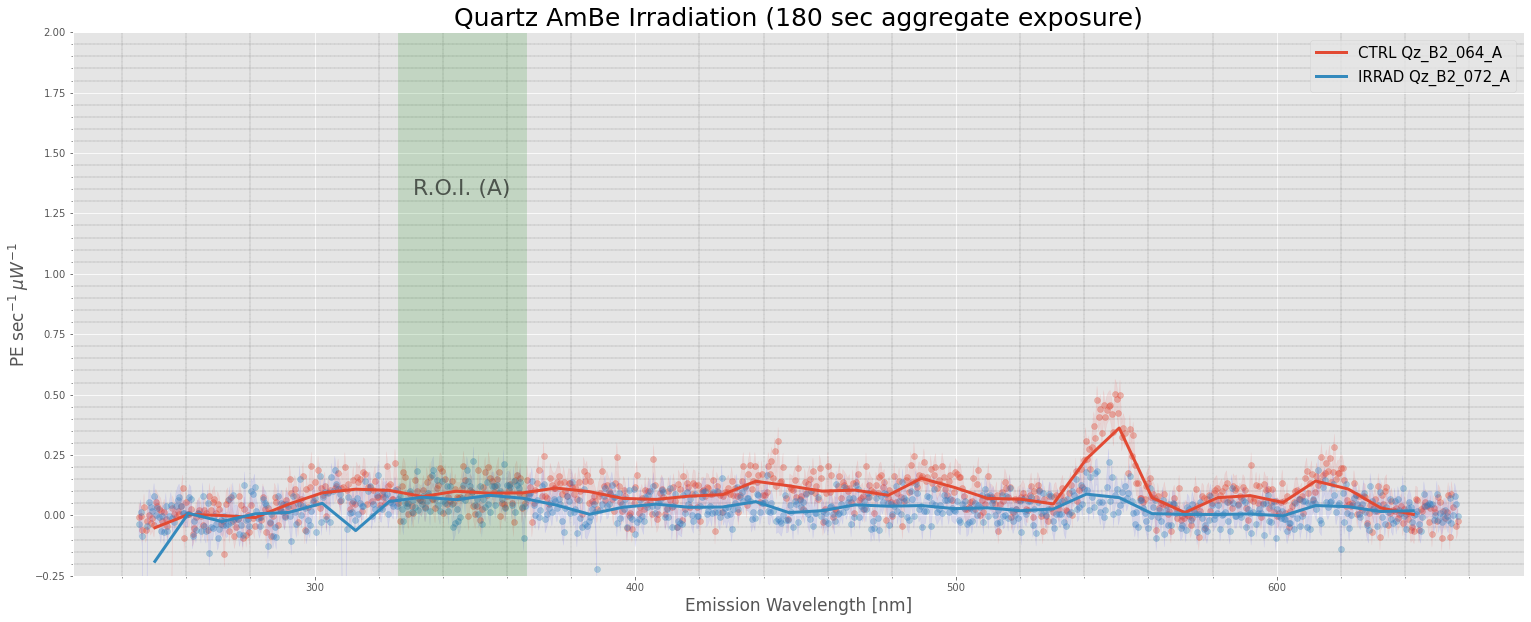

In [71]:
sample = 'Qz_B2_064_A'
wl           = '250'
group  = Qz_ctrl
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'CTRL',err_color = 'red')
plt.ylim(-0.25, 2)

sample = 'Qz_B2_072_A'
wl           = '250'
group  = Qz_irrad
model = 'ambience_250'
ratio = ratio_250

df = run_analysis(group, sample, wl, model, ratio, toplot = True, add_label = 'IRRAD',show_err=True)
plt.ylim(-0.25, 2)

# ROI
plt.axvspan(326, 366, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(346, 1.35, 'R.O.I. (A)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Quartz AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

---

## Data Display (B-Centres)

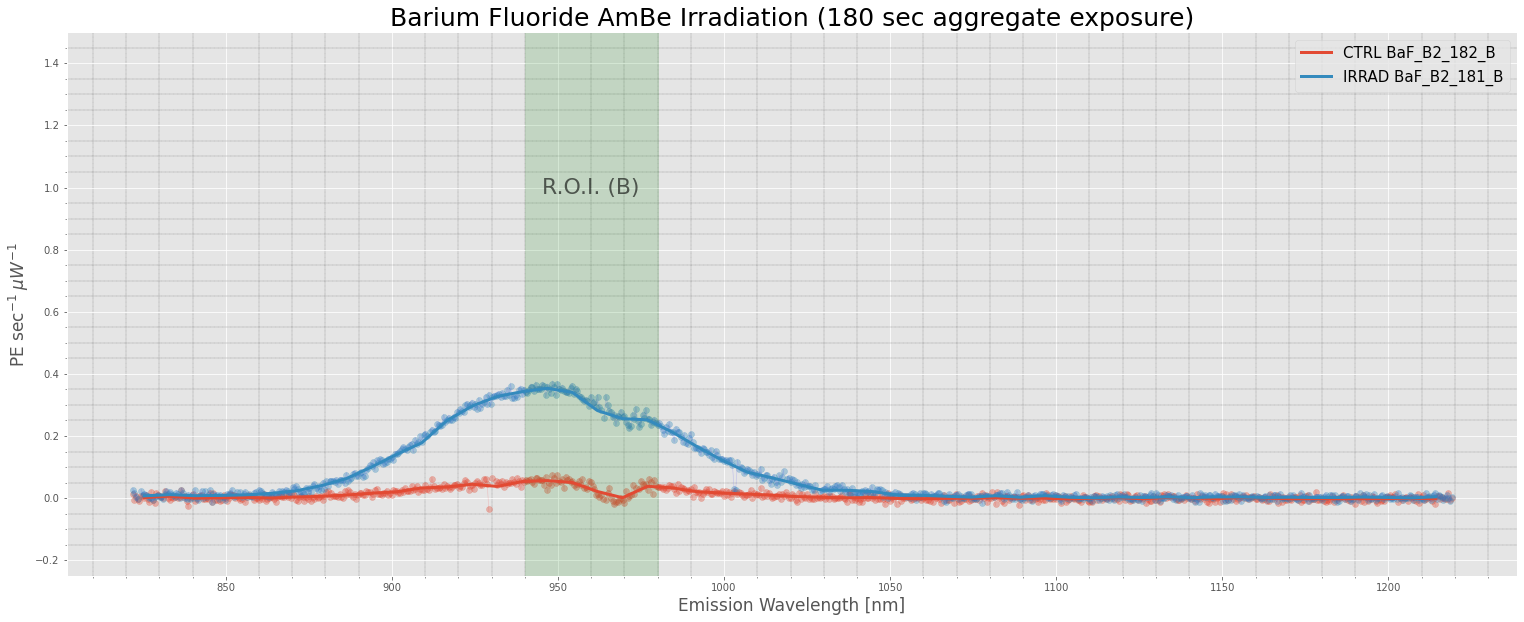

In [72]:
sample = 'BaF_B2_182_B'
wl           = '320'
group  = BaF_ctrl
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)

sample = 'BaF_B2_181_B'
wl           = '320'
group  = BaF_irrad
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 1.5)

# ROI
plt.axvspan(940, 980, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(960, 1, 'R.O.I. (B)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

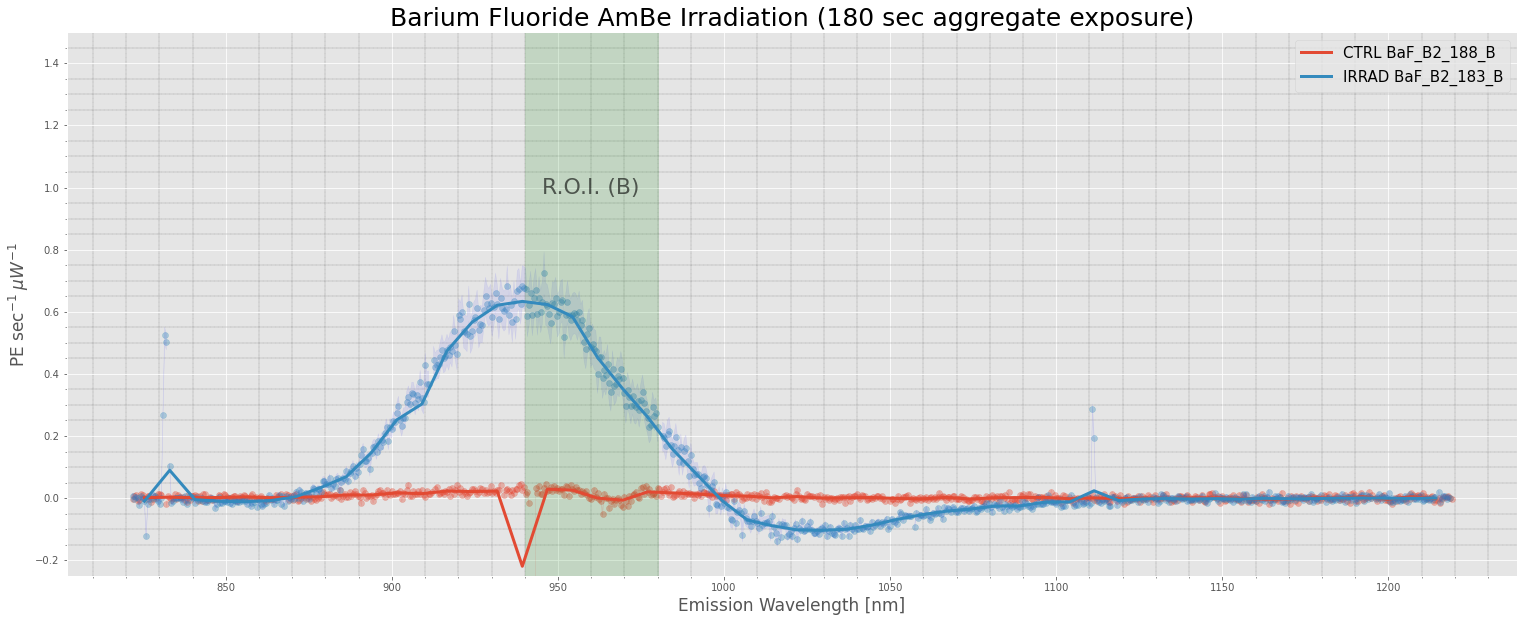

In [73]:
sample = 'BaF_B2_188_B'
wl           = '320'
group  = BaF_ctrl
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)

sample = 'BaF_B2_183_B'
wl           = '320'
group  = BaF_irrad
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 1.5)

# ROI
plt.axvspan(940, 980, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(960, 1, 'R.O.I. (B)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

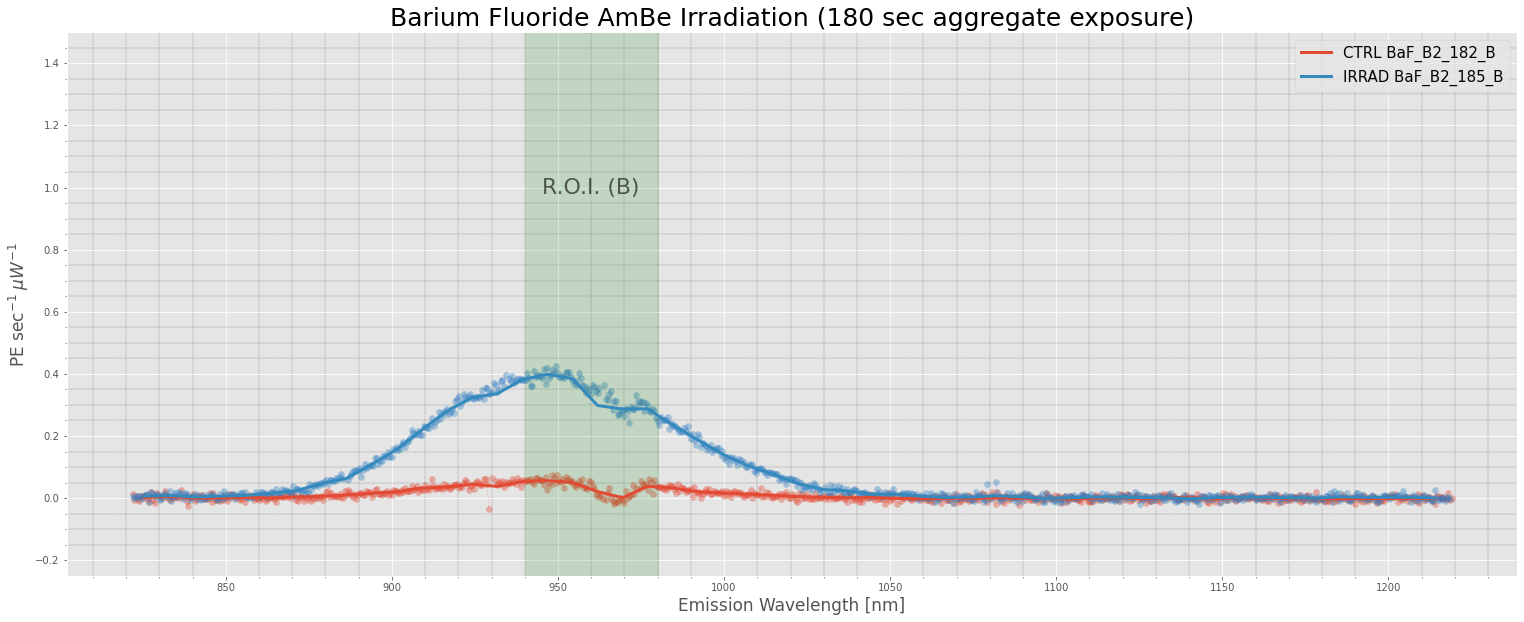

In [74]:
sample = 'BaF_B2_182_B'
wl           = '320'
group  = BaF_ctrl
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)

sample = 'BaF_B2_185_B'
wl           = '320'
group  = BaF_irrad
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 1.5)

# ROI
plt.axvspan(940, 980, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(960, 1, 'R.O.I. (B)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

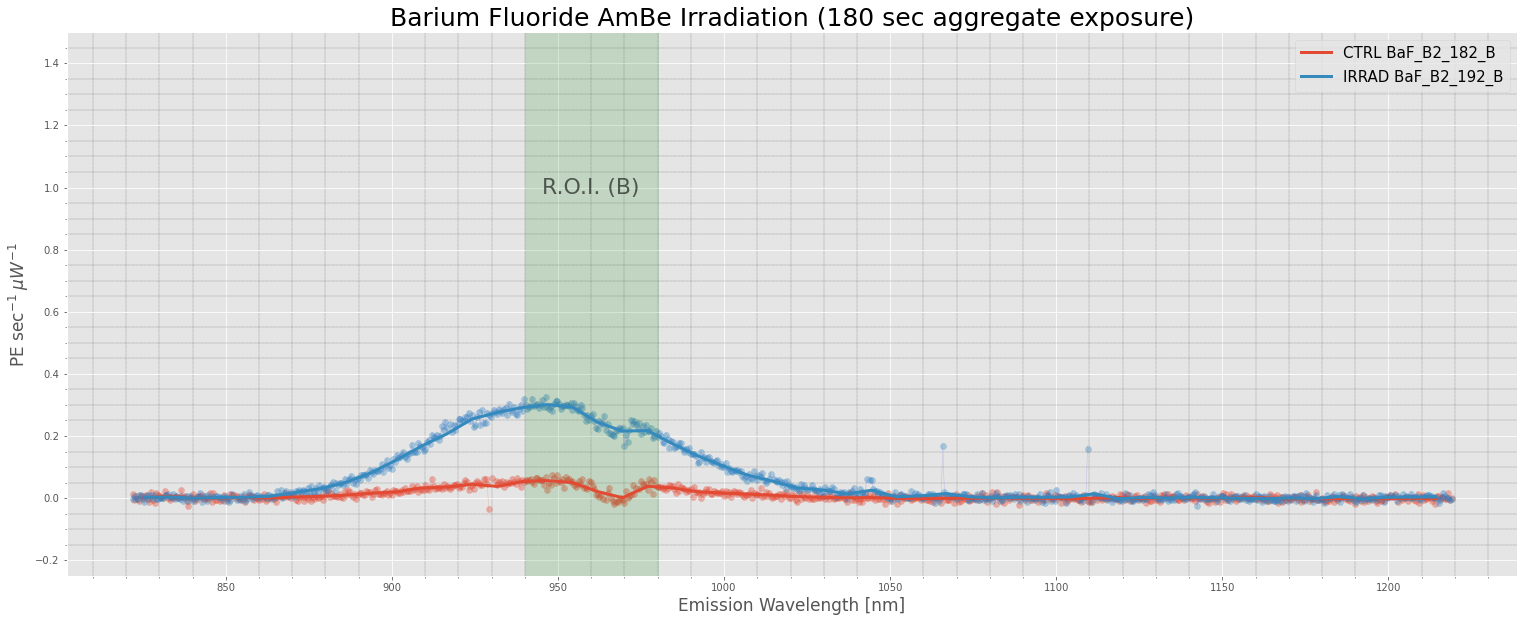

In [75]:
sample = 'BaF_B2_182_B'
wl           = '320'
group  = BaF_ctrl
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)

sample = 'BaF_B2_192_B'
wl           = '320'
group  = BaF_irrad
model = 'ambience_320'
ratio = ratio_320

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 1.5)

# ROI
plt.axvspan(940, 980, alpha=0.15, color='green')
#plt.legend()

# Add text to the plot
plt.text(960, 1, 'R.O.I. (B)', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Barium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

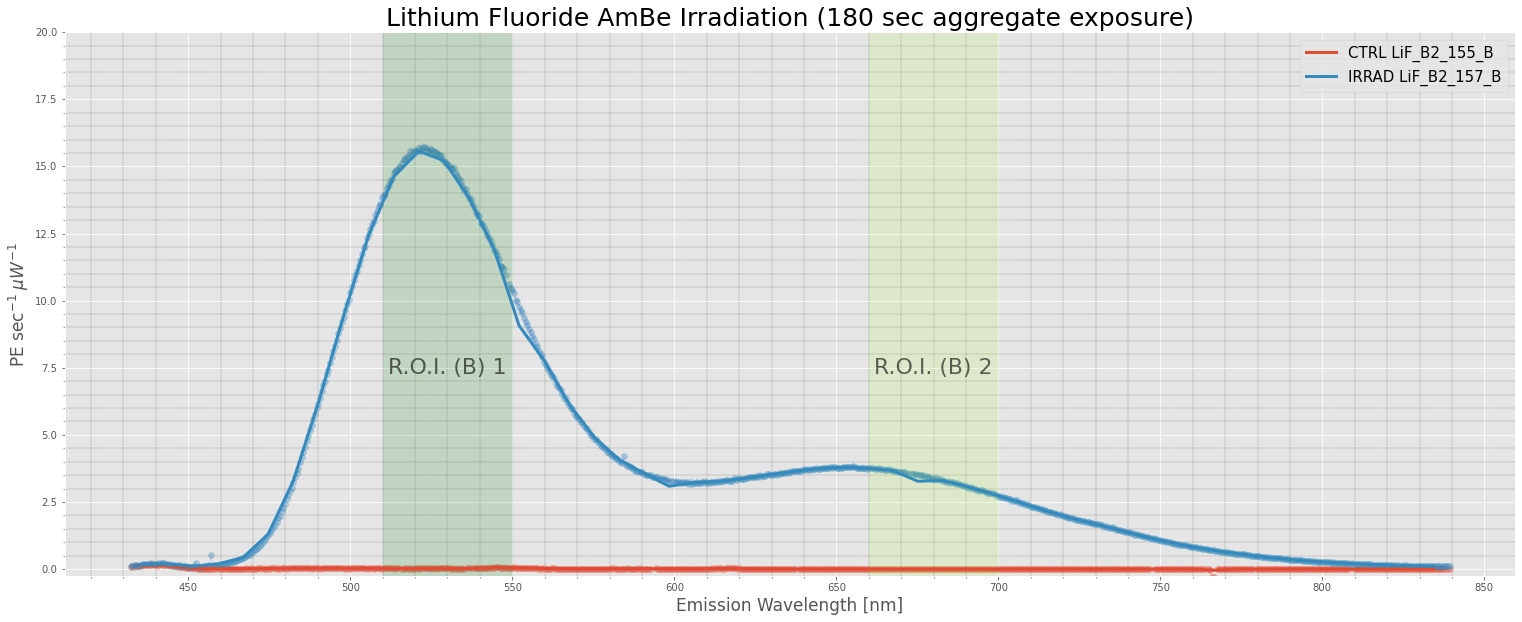

In [76]:
sample = 'LiF_B2_155_B'
wl           = '435'
group  = LiF_ctrl
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)
#plt.ylim(-0.25, 2)

sample = 'LiF_B2_157_B'
wl           = '435'
group  = LiF_irrad
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 20)

# ROI
plt.axvspan(510, 550, alpha=0.15, color='green')
plt.axvspan(660, 700, alpha=0.15, color='greenyellow')

# Add text to the plot
plt.text(530, 7.5, 'R.O.I. (B) 1', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.text(680, 7.5, 'R.O.I. (B) 2', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

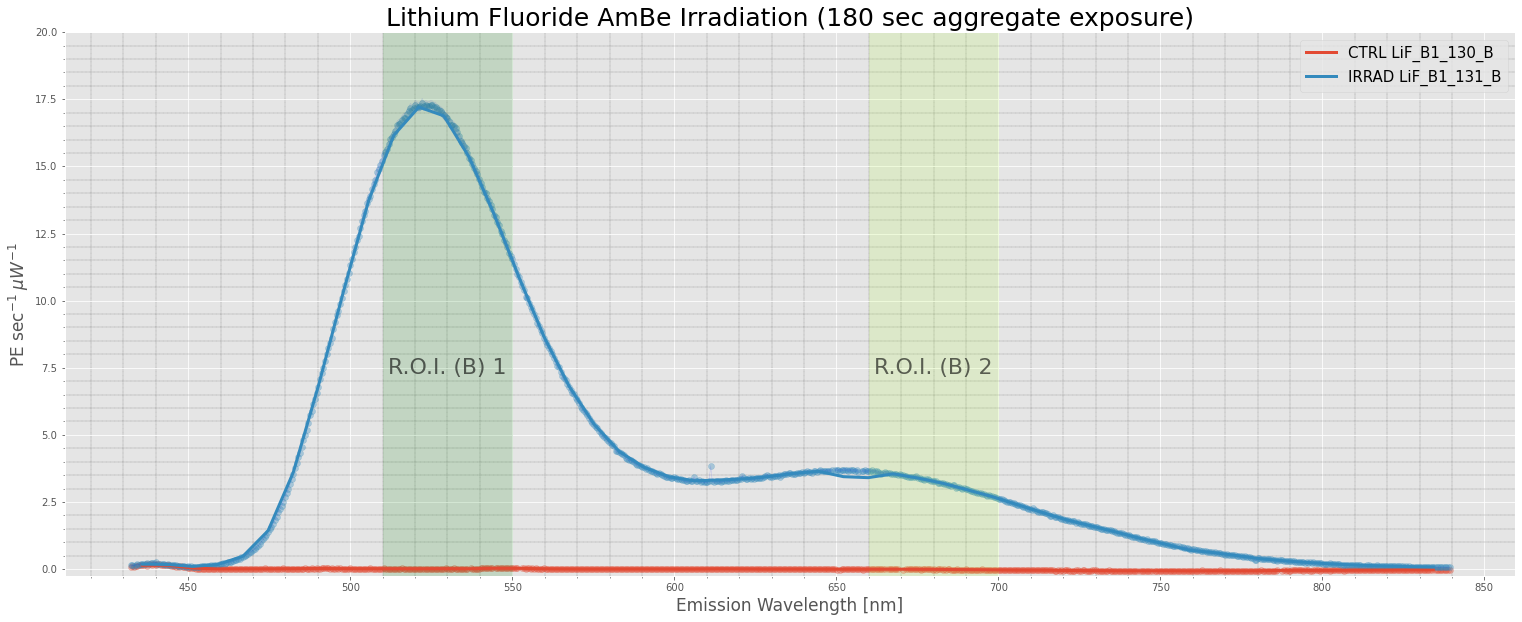

In [77]:
sample = 'LiF_B1_130_B'
wl           = '435'
group  = LiF_ctrl
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)
#plt.ylim(-0.25, 2)

sample = 'LiF_B1_131_B'
wl           = '435'
group  = LiF_irrad
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 20)

# ROI
plt.axvspan(510, 550, alpha=0.15, color='green')
plt.axvspan(660, 700, alpha=0.15, color='greenyellow')

# Add text to the plot
plt.text(530, 7.5, 'R.O.I. (B) 1', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.text(680, 7.5, 'R.O.I. (B) 2', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

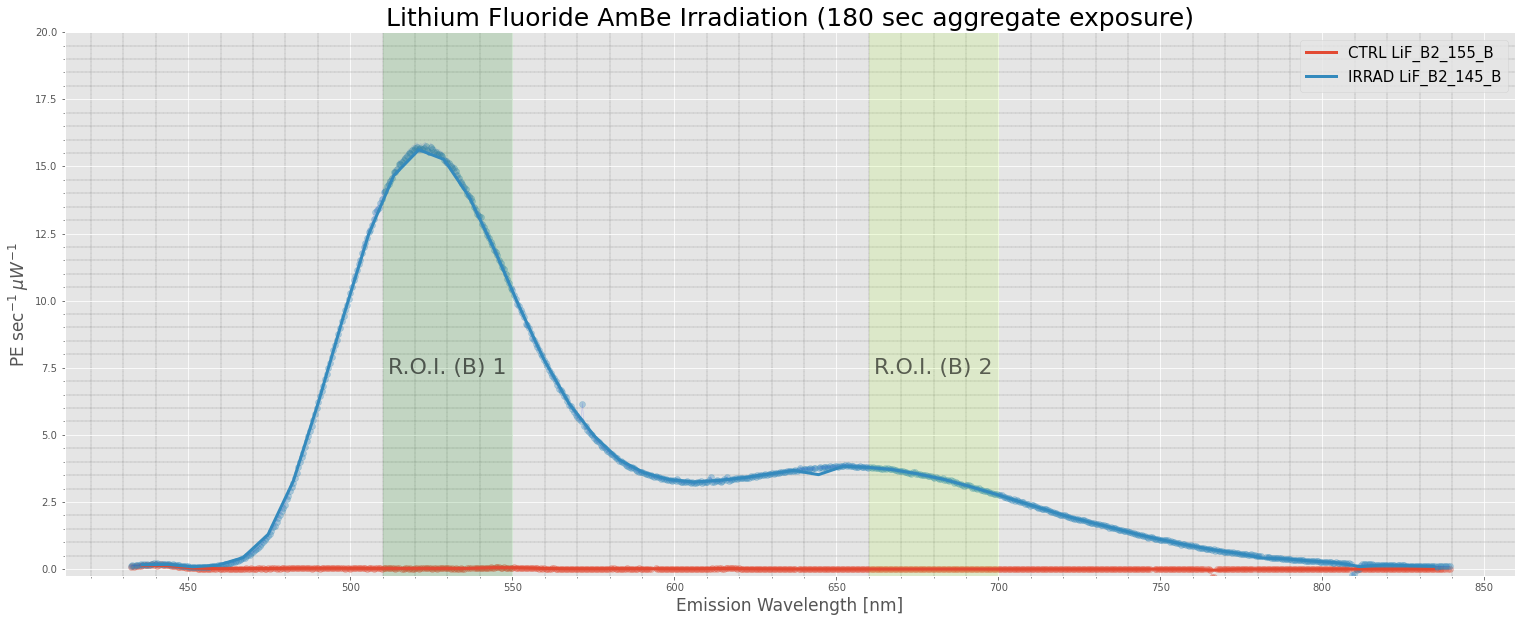

In [78]:
sample = 'LiF_B2_155_B'
wl           = '435'
group  = LiF_ctrl
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)
#plt.ylim(-0.25, 2)

sample = 'LiF_B2_145_B'
wl           = '435'
group  = LiF_irrad
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 20)

# ROI
plt.axvspan(510, 550, alpha=0.15, color='green')
plt.axvspan(660, 700, alpha=0.15, color='greenyellow')

# Add text to the plot
plt.text(530, 7.5, 'R.O.I. (B) 1', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.text(680, 7.5, 'R.O.I. (B) 2', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

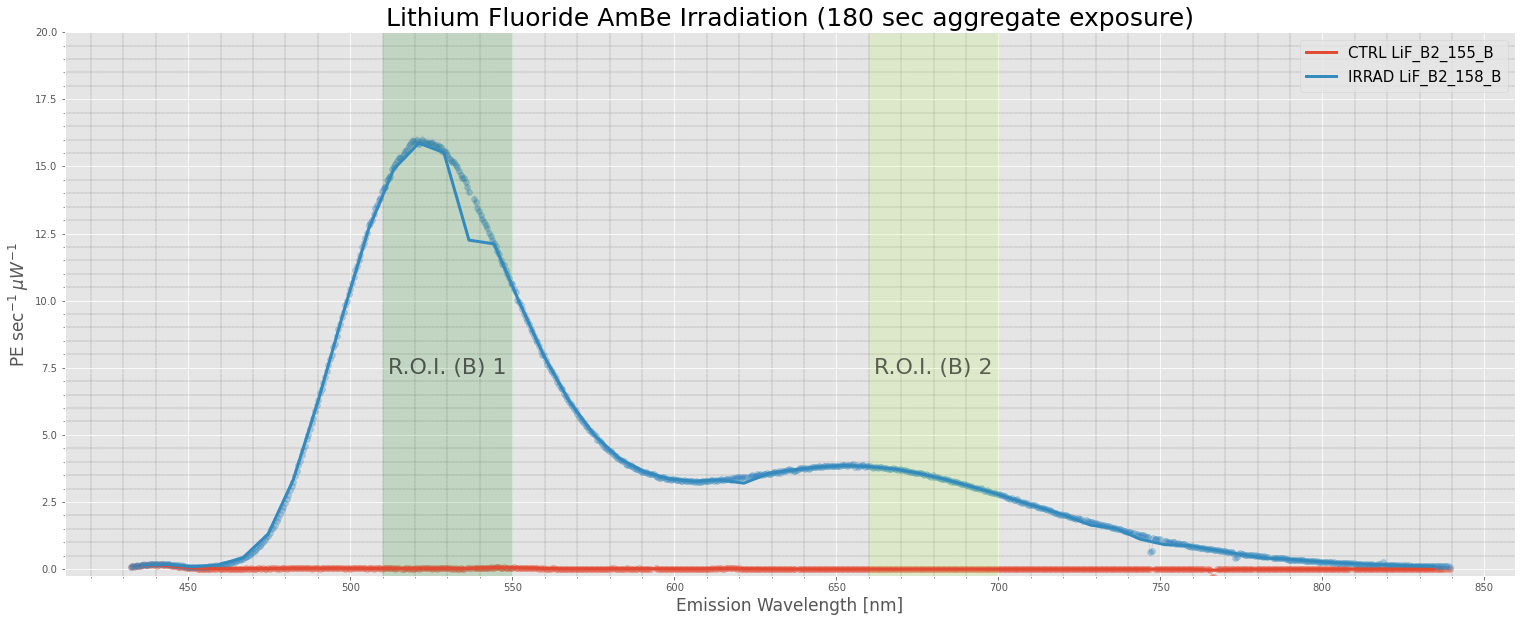

In [79]:
sample = 'LiF_B2_155_B'
wl           = '435'
group  = LiF_ctrl
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, err_color = 'red', add_label = 'CTRL', bins = 15)
#plt.ylim(-0.25, 2)

sample = 'LiF_B2_158_B'
wl           = '435'
group  = LiF_irrad
model = 'ambience_435'
ratio = ratio_435

df = run_analysis(group, sample, wl, model, ratio, toplot = True, show_err=True, add_label = 'IRRAD', bins = 15)
plt.ylim(-0.25, 20)

# ROI
plt.axvspan(510, 550, alpha=0.15, color='green')
plt.axvspan(660, 700, alpha=0.15, color='greenyellow')

# Add text to the plot
plt.text(530, 7.5, 'R.O.I. (B) 1', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.text(680, 7.5, 'R.O.I. (B) 2', fontsize=22, ha='center', va='center', color='black', alpha = 0.6)

plt.title('Lithium Fluoride AmBe Irradiation (180 sec aggregate exposure)', fontsize = 25);

---

## Fitting the Data

### LiF

In [80]:
sample = 'LiF_B2_157_B'
wl           = '435'

s1_lif = norm_df(LiF_irrad, sample, 3, wl, ambience_435, ratio_435)
s2_lif = norm_df(LiF_irrad, sample, 6, wl, ambience_435, ratio_435)
ds_lif = diff_df(s2_lif,s1_lif)

x = ds_lif['em_wl']; y = ds_lif['count']; err = ds_lif['error']
x, y, e = remove_nans(ds_lif['em_wl'], ds_lif['count'], ds_lif['error'])

combined_error = np.round(np.sqrt(np.sum(err**2)), 1)
area                        = np.round(np.trapz(y),1)

print(f'Area = {area}  ({combined_error})')

Area = 3042.1  (1.0)


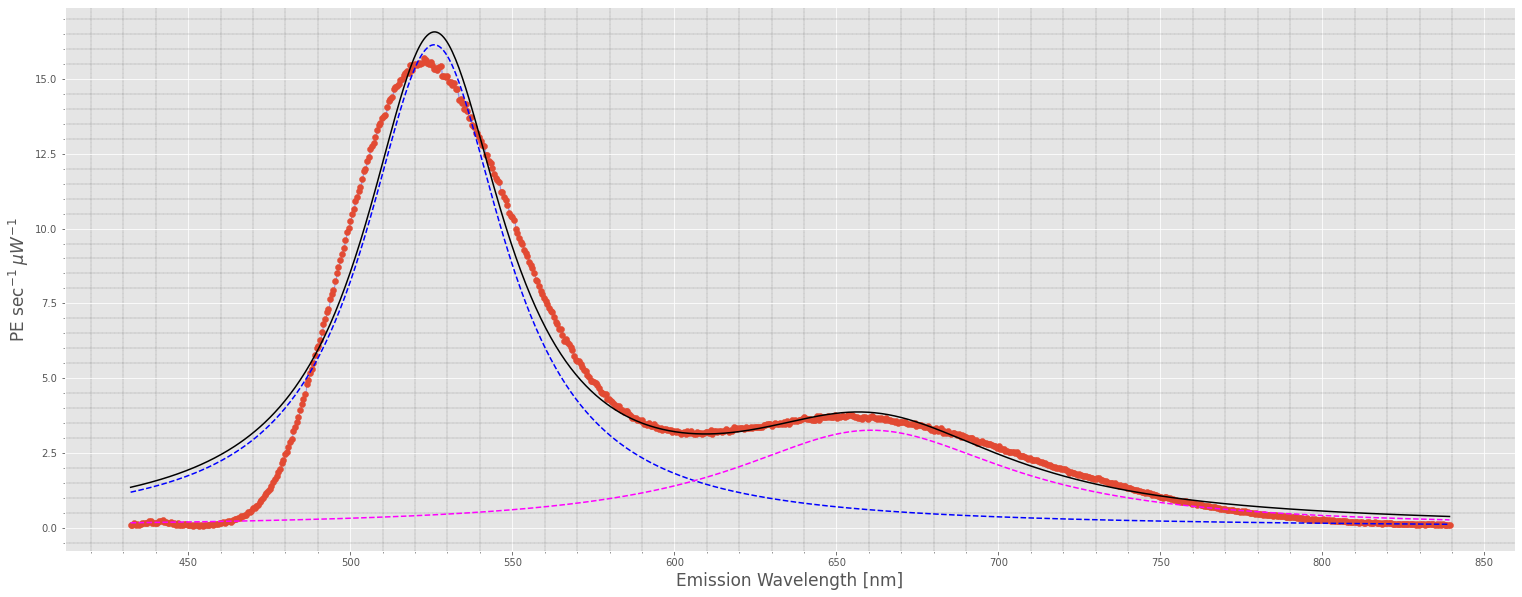

In [81]:
# 2 Lorentzians

x, y, e = remove_nans(ds_lif['em_wl'], ds_lif['count'], ds_lif['error'])
#popt, pcov = curve_fit(Gaussian3, x, y, sigma = e*0.01, absolute_sigma=False, p0 = [16,5, 10 , 500, 550, 650, 20, 20, 50])
popt, pcov = curve_fit(lorentzian2, x, y, p0 = [1200, 500, 50, 1200, 650, 50])

plt.fill_between(x, y - e, y + e, alpha=0.25, color = 'blue', label='Error Region')
plt.scatter(x, y)
plt.plot(x , lorentzian2(x, *popt), color = 'black')
plt.plot(x , lorentzian(x, *popt[:3]), color = 'blue', linestyle = '--')
plt.plot(x , lorentzian(x, *popt[3:6]), color = 'fuchsia',  linestyle = '--')

plt.xlabel('Emission Wavelength [nm]', fontsize = 17)
plt.ylabel(r'PE sec$^{-1} \; \mu W^{-1}$', fontsize = 17)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()

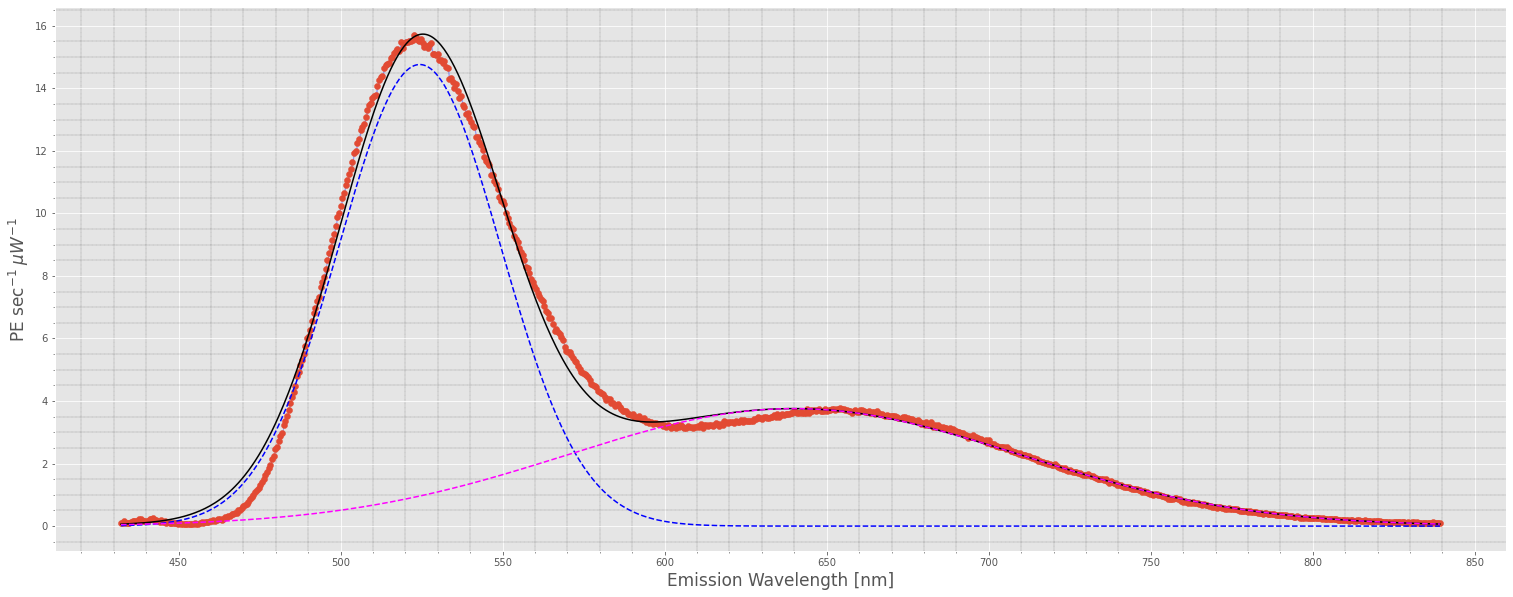

In [82]:
# 2 Gaussians

x, y, e = remove_nans(ds_lif['em_wl'], ds_lif['count'], ds_lif['error'])
#popt, pcov = curve_fit(Gaussian3, x, y, sigma = e*0.01, absolute_sigma=False, p0 = [16,5, 10 , 500, 550, 650, 20, 20, 50])
popt, pcov = curve_fit(Gaussian2, x, y, p0 = [20, 500, 20, 10, 550, 20])

plt.fill_between(x, y - e, y + e, alpha=0.25, color = 'blue', label='Error Region')
plt.scatter(x, y)
plt.plot(x , Gaussian2(x, *popt), color = 'black')
plt.plot(x , Gaussian(x, *popt[:3]), color = 'blue', linestyle = '--')
plt.plot(x , Gaussian(x, *popt[3:6]), color = 'fuchsia',  linestyle = '--')

plt.xlabel('Emission Wavelength [nm]', fontsize = 17)
plt.ylabel(r'PE sec$^{-1} \; \mu W^{-1}$', fontsize = 17)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()

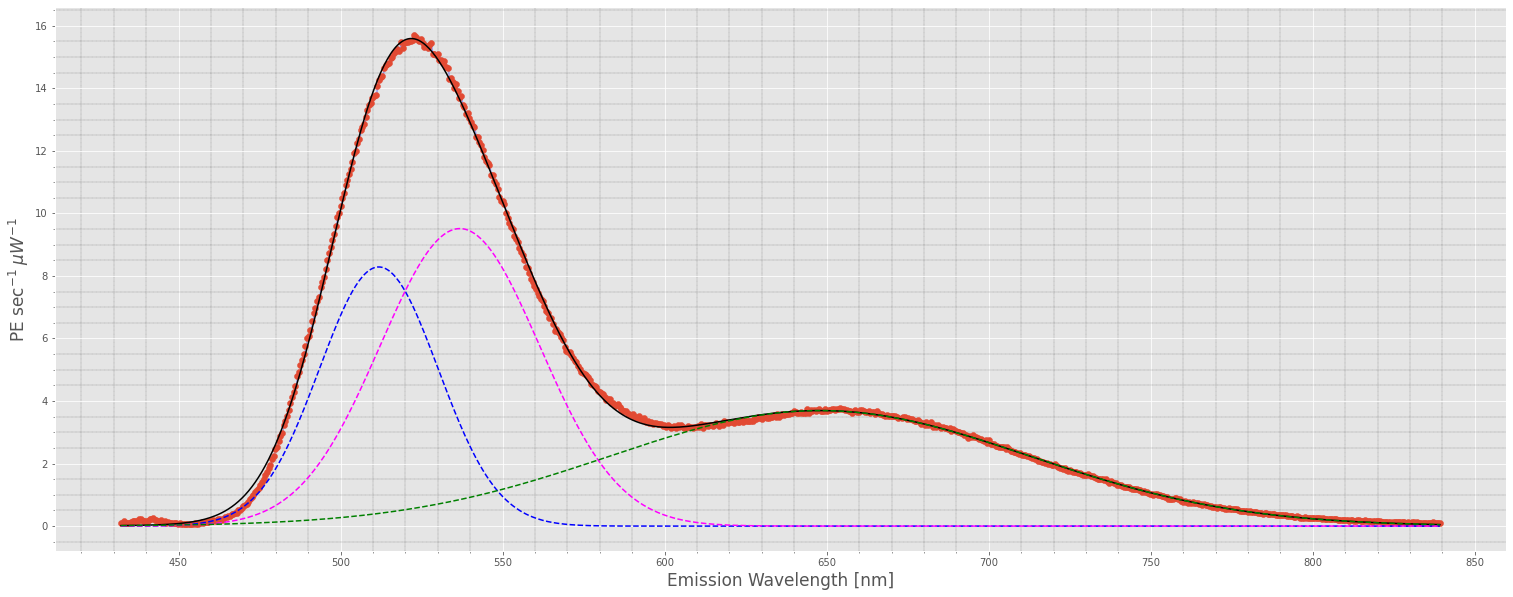

In [83]:
# 3 Gaussians

x, y, e = remove_nans(ds_lif['em_wl'], ds_lif['count'], ds_lif['error'])
#popt, pcov = curve_fit(Gaussian3, x, y, sigma = e*0.01, absolute_sigma=False, p0 = [16,5, 10 , 500, 550, 650, 20, 20, 50])
popt, pcov = curve_fit(Gaussian3, x, y, p0 = [20, 500, 20, 10, 550, 20, 10, 650, 10])

plt.fill_between(x, y - e, y + e, alpha=0.25, color = 'blue', label='Error Region')
plt.scatter(x, y)
plt.plot(x , Gaussian3(x, *popt), color = 'black')
plt.plot(x , Gaussian(x, *popt[:3]), color = 'blue',  linestyle = '--')
plt.plot(x , Gaussian(x, *popt[3:6]), color = 'fuchsia',  linestyle = '--')
plt.plot(x , Gaussian(x, *popt[6:9]), color = 'green',  linestyle = '--')

plt.xlabel('Emission Wavelength [nm]', fontsize = 17)
plt.ylabel(r'PE sec$^{-1} \; \mu W^{-1}$', fontsize = 17)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()

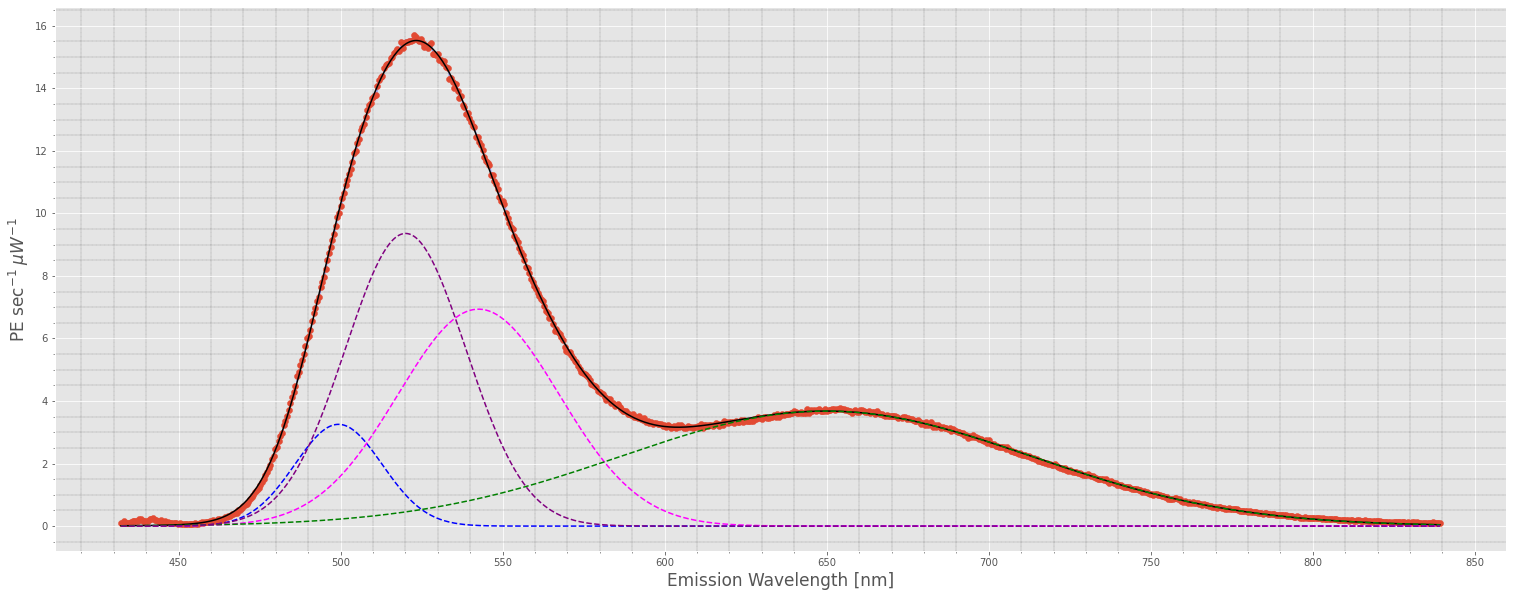

In [84]:
# 4 Gaussians

x, y, e = remove_nans(ds_lif['em_wl'], ds_lif['count'], ds_lif['error'])
#popt, pcov = curve_fit(Gaussian3, x, y, sigma = e*0.01, absolute_sigma=False, p0 = [16,5, 10 , 500, 550, 650, 20, 20, 50])
popt, pcov = curve_fit(Gaussian4, x, y, p0 = [20, 500, 20, 10, 550, 20, 10, 650, 10, 10, 550, 20])

plt.fill_between(x, y - e, y + e, alpha=0.25, color = 'blue', label='Error Region')
plt.scatter(x, y)
plt.plot(x , Gaussian4(x, *popt), color = 'black')
plt.plot(x , Gaussian(x, *popt[:3]), color = 'blue',  linestyle = '--')
plt.plot(x , Gaussian(x, *popt[3:6]), color = 'fuchsia',  linestyle = '--')
plt.plot(x , Gaussian(x, *popt[6:9]), color = 'green',  linestyle = '--')
plt.plot(x , Gaussian(x, *popt[9:12]), color = 'purple',  linestyle = '--')

plt.xlabel('Emission Wavelength [nm]', fontsize = 17)
plt.ylabel(r'PE sec$^{-1} \; \mu W^{-1}$', fontsize = 17)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()

### BaF

In [85]:
sample = 'BaF_B2_181_B'
wl           = '320'

s1_baf = norm_df(BaF_irrad, sample, 3, wl, ambience_320, ratio_320)
s2_baf = norm_df(BaF_irrad, sample, 6, wl, ambience_320, ratio_320)
ds_baf = diff_df(s2_baf,s1_baf)

x = ds_baf['em_wl']; y = ds_baf['count']; err = ds_baf['error']

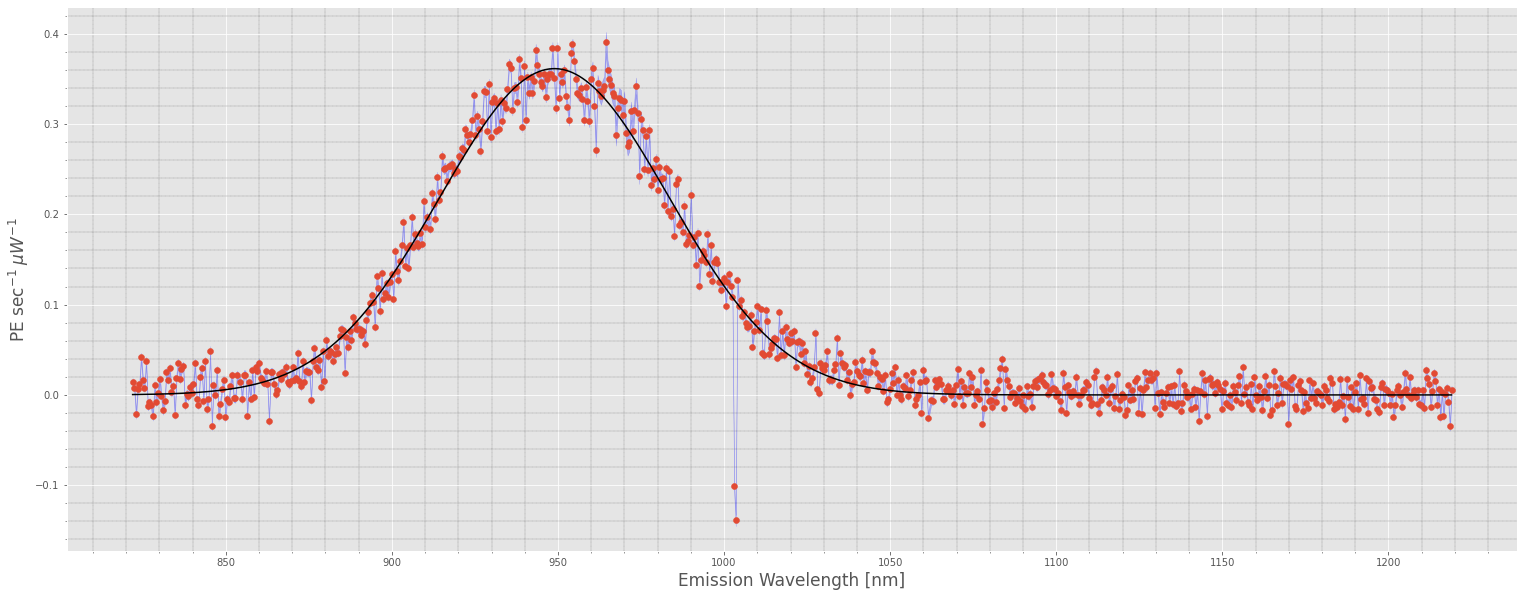

In [86]:
# 1 Gaussian

x, y, e = remove_nans(ds_baf['em_wl'], ds_baf['count'], ds_baf['error'])
#popt, pcov = curve_fit(Gaussian3, x, y, sigma = e*0.01, absolute_sigma=False, p0 = [16,5, 10 , 500, 550, 650, 20, 20, 50])
popt, pcov = curve_fit(Gaussian, x, y, p0 = [1, 900, 30])

plt.fill_between(x, y - e, y + e, alpha=0.25, color = 'blue', label='Error Region')
plt.scatter(x, y)
plt.plot(x , Gaussian(x, *popt), color = 'black')


plt.xlabel('Emission Wavelength [nm]', fontsize = 17)
plt.ylabel(r'PE sec$^{-1} \; \mu W^{-1}$', fontsize = 17)
plt.grid(visible=True, which='minor', color='black', linestyle='--', linewidth=0.25, alpha = 0.75) 
plt.minorticks_on()